# Generative Adversarial Imitation Learning (GAIL)

Generative Adversarial Imitation Learning (GAIL) is the method inspired by IRL (Inverse Reinforcement Learning) and GANs (Generative Adversarial Networks), in which discriminator network is used to distinguish true data from false data.

Unlike previous IRL methods, GAIL constrains the behavior of the agent to be approximately optimal without explicitly recovering the reward's function, i.e, it scales an IRL approach by bypassing intermediate IRL steps (bypassing steps for learning a cost or reward function).<br>
It directly extracts a policy from data, **as if it were obtained by reinforcement learning following inverse
reinforcement learning**. (RL algorithms discussed in [here](https://github.com/tsmatz/reinforcement-learning-tutorials) can also be applied in GAIL.)

Up until now, we assumed that the rewards $\mathbf{w}$ is linear to the feature of trajectory, $\verb|reward| = \mathbf{w}^T \cdot \phi(\tau)$.<br>
GAIL, however, doesn't need this constraint, and can then imitate arbitrarily complex expert behaviors.

GAIL is one of SOTA (state-of-the-art) imitation learning algorithms.

*(back to [index](https://github.com/tsmatz/imitation-learning-tutorials/))*

## Overview of Generative Adversarial Imitation Learning (GAIL) method

Let's briefly follow theoretical aspects behind GAIL algorithm along with the original paper [[Ho and Ermon, 2016](https://arxiv.org/pdf/1606.03476)].

Maximum Causal Entropy (MCE) IRL is one of successful IRL algorithms.<br>
As we have discussed in [MCE IRL example](./04_mce_irl.ipynb), Maximum Causal Entropy IRL finds a cost function (see below note) to maximize the entropy $-H(\pi)$ and expectation.<br>
IRL operation in abstraction can then be written as :

$\displaystyle IRL(\pi_E) = \max_{c \in \mathcal{C}} \left( \min_{\pi \in \Pi} \left( -H(\pi) + \mathbb{E}_{\pi}[c(s,a)] \right) - \mathbb{E}_{\pi_E}[c(s,a)] \right)$

where $\mathcal{C}$ is a set of cost functions.

> Note : Unlike [MCE IRL example](./04_mce_irl.ipynb), the function $c()$ is not a reward function, but a cost function. The cost function is **minimized (not maximized)** for optimization.

To prevent from [overfitting](https://tsmatz.wordpress.com/2017/09/13/overfitting-for-regression-and-deep-learning/) in machine learning problems, we introduce a regularizer, $\psi : \mathbb{R}^{\mathcal{S} \times \mathcal{A}} \to \mathbb{R} \cup \{ \infty \}$, and apply in this equation. :

$\displaystyle IRL_{\psi}(\pi_E) = \arg \max_{c \in \mathbb{R}^{\mathcal{S} \times \mathcal{A}}} \left( -\psi(c) + \min_{\pi \in \Pi} \left( -H(\pi) + \mathbb{E}_{\pi}[c(s,a)] \right) - \mathbb{E}_{\pi_E}[c(s,a)] \right) \;\;\;\;\;\; (1) $

Now we introduce the occupancy measure which is often used in the theory of RL.

First, we define the occupancy measure $\rho_{\pi}(s, a) : \mathcal{S} \times \mathcal{A} \to \mathbb{R}$ for $\pi$ as :

$\displaystyle \rho_{\pi}(s, a) \coloneqq \pi(a | s) \sum_{t=0}^{\infty} \gamma^t P(s_t=s|\pi) $

> Note : $P(s_t=s|\pi)$ is the probability of landing in state $s$.

In abstraction, the occupancy measure is the probability of state's occurrence when navigating the environment with policy $\pi$.

When we denote a set of valid occupancy measures $\{ \rho_{\pi} : \pi \in \Pi \}$ as $\mathcal{D}$, it's known that there is a one-to-one correspondence between $\Pi$ and $\mathcal{D}$. (i.e, When some $\rho$ is given, the corresponding $\pi$ to satisfy $\rho = \rho_\pi$ is uniquely determined.)

Using occupancy measures, it's known that to find the optimal $\pi$ under a cost function obtained in (1) is equivalent to :

$\displaystyle RL \circ IRL_{\psi}(\pi_E) = \arg \min_{\pi \in \Pi} \left( -H(\pi) + \psi^* \left( \rho_{\pi} - \rho_{\pi_E} \right) \right) \;\;\;\;\;\; (2)$

where $\psi^* : \mathbb{R}^{\mathcal{S} \times \mathcal{A}} \to \mathbb{R} \cup \{ \infty \}$ is the [convex conjugate](https://en.wikipedia.org/wiki/Convex_conjugate) of $\psi$.

Especially, when $\psi$ is constant and $\pi$ is then obtained by (2), it's known that $\rho_{\pi} = \rho_{\pi_E}$.

> Note : See [original paper](https://arxiv.org/pdf/1606.03476) and its Appendix A.1 for this proof.

This implicitly means that $\psi$-regularized IRL is to seek a policy whose occupancy measure is close to the expert, as measured by the convex function $\psi^*$. If $\psi$ is constant, the solution of (2) simply matches occupancy measures with expert at all states and actions.<br>
Here I don't go so far into details, but it's also known that the expectation matching with linear cost function (which are discussed in previous examples) is the special case of above (2). (See description about apprenticeship learning in [original paper](https://arxiv.org/pdf/1606.03476) for details.)

Now let $\psi_{GA}()$ be the following regularization function. :

$\displaystyle \psi_{GA}(c) \coloneqq \mathbb{E}_{\pi_E}[g(c(s,a))] $  when $c \lt 0$

$\displaystyle \psi_{GA}(c) \coloneqq +\infty $  otherwise

where

$\displaystyle g(x) \coloneqq -x-\log(1-e^x) $  when $x \lt 0$

$\displaystyle g(x) \coloneqq +\infty $  otherwise

This regularization forces that the cost function $c$ is always negative, and penalitizes for small $c$ and large $c$ (close to zero), because the plot of function $g(x)$ is as follows. :

<img src="./assets/regularization_plot.png" alt="Regularization Plot" width="300"/>

Unlike linear cost functions (or linear reward functions) seen in previous IRL examples, $\psi_{GA}()$ allows for any cost function, as long as it is negative everywhere, and $RL \circ IRL_{\psi}(\pi_E)$ can be fitted to more complex cost estimation.

Under this assumption, it's known that it holds the following equation. (See [original paper](https://arxiv.org/pdf/1606.03476) for the proof.)

$\displaystyle \psi_{GA}^* (\rho_{\pi} - \rho_{\pi_E}) = \max_{D \in (0,1)^{\mathcal{S} \times \mathcal{A}}} \left( \mathbb{E}_{\pi} [\log(D(s, a))] + \mathbb{E}_{\pi_E} [\log(1 - D(s, a))] \right) \;\;\;\;\;\; (3) $

where $D$ is discriminative classifier $D : \mathcal{S} \times \mathcal{A} \to (0,1)$.

Now we assume that the learner's policy $\pi$ is parameterized by $\theta$ (i.e, $\pi = \pi_{\theta}$) and the discriminator network $D$ is parameterized by $w$ (i.e, $D = D_w$).

By above (2) and (3), our algorithm (GAIL) is to alternately update $w$ and $\theta$ as follows. :

- Update $w$ to increase $\mathbb{E}_{\pi} [\log(D(s, a))] + \mathbb{E}_{\pi_E} [\log(1 - D(s, a))]$.
- Update $\theta$ to decrease $\mathbb{E}_{\pi} [\log(D(s, a))] - \lambda H(\pi) $ using the updated discriminator $D(s,a)$, where $\lambda \geq 0$ is a controlling coefficient.

In [original paper](https://arxiv.org/pdf/1606.03476), Adam gradient step is applied to update $w$, and TRPO (trust region policy optimization) algorithm is used to update $\theta$ in order to avoid unstable policy updates.<br>
As you'll see later, we'll however use PPO (proximal policy optimization) instead of TRPO in this example.

## Implementation

### 1. Restore environment and load expert's data

Before we start, we need to install the required packages.

In [ ]:
!pip install torch numpy matplotlib

Firstly, I restore GridWorld environment from JSON file. (See [this script](./00_generate_expert_trajectories.ipynb) for generating the same environment.)

I note that I'll apply temporal difference (TD) learning (see [here](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/03-actor-critic.ipynb)) in this example, and the difference between termination and truncation is important.<br>
Thus, by setting ```max_timestep=None```, the truncation is not performed in this environment, and I'll handle the truncation during the training by myself.

In [1]:
import torch
import json
from gridworld import GridWorld

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open("gridworld.json", "r") as f:
    json_object = json.load(f)
    env = GridWorld(**json_object, max_timestep=None, device=device)

Now I visualize our GridWorld environment.

The number in each cell indicates the reward score on this state.<br>
The goal state is on the right-bottom corner (in which the reward is ```10.0```), and the initial state is uniformly picked up from the gray-colored cells.<br>
If the agent can reach to goal state without losing any rewards, it will get ```10.0``` for total reward.

See [Readme.md](https://github.com/tsmatz/imitation-learning-tutorials/blob/master/Readme.md) for details about the game rule of this environment.

In [2]:
from IPython.display import HTML, display

valid_states_all = torch.cat((env.valid_states, torch.tensor([env.grid_size-1,env.grid_size-1]).to(device).unsqueeze(dim=0)))
valid_states_all = valid_states_all[:,0] * env.grid_size + valid_states_all[:,1]

html_text = "<table>"
for row in range(env.grid_size):
    html_text += "<tr>"
    for col in range(env.grid_size):
        if row*env.grid_size + col in valid_states_all:
            html_text += "<td bgcolor=\"gray\">"
        else:
            html_text += "<td>"
        html_text += str(env.reward_map[row*env.grid_size+col].tolist())
        html_text += "</td>"
    html_text += "</tr>"
html_text += "</table>"

display(HTML(html_text))

0,-1,0,0,0,-1,0,0,0,0,0,0,-1,0,-1,-1,-1,-1,0,-1,0,-1,0,0,0,-1,0,0,0,-1,-1,0,-1,0,0,0,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0
-1,0,0,0,0,-1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,0,-1,0,0,0,0,0,-1,0,-1,0,-1,0,-1,0,-1,-1,0,0,0,-1,-1,0,0,-1,-1
0,0,-1,-1,0,-1,0,-1,0,-1,0,0,0,0,0,0,0,-1,0,0,-1,0,0,-1,0,0,0,0,0,0,0,-1,0,0,-1,0,0,-1,-1,0,0,-1,0,0,0,0,-1,0,0,0
0,0,-1,0,-1,-1,0,0,-1,0,-1,0,0,0,0,-1,0,-1,0,-1,0,-1,0,0,-1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,-1
-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,-1,0,0,0,-1,0,0,-1,0,-1,-1,0,0
0,-1,-1,0,0,-1,0,-1,0,0,-1,0,0,-1,0,0,-1,-1,0,0,-1,0,0,0,-1,0,0,0,0,-1,-1,0,0,-1,0,-1,-1,-1,-1,0,0,-1,0,-1,0,0,0,0,0,-1
-1,-1,0,0,0,0,0,0,0,0,0,0,-1,0,-1,0,0,0,0,0,-1,-1,0,0,-1,-1,0,0,-1,-1,0,-1,0,0,0,0,0,0,0,-1,-1,0,0,0,-1,0,-1,0,-1,-1
0,0,0,0,-1,0,0,0,-1,0,0,0,0,-1,0,0,-1,-1,0,0,-1,0,0,-1,0,0,-1,0,0,0,-1,-1,0,0,-1,0,-1,0,-1,0,0,-1,0,-1,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,-1,-1,0,-1,0,0,-1,0,0,-1,-1,0,0,0,0,0,0,-1,0,0,0,-1,-1,-1,-1,-1,-1,0,-1,-1,0,-1,0,0,0,-1,0,0,0,0
0,0,0,-1,0,-1,0,0,-1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,-1,-1,-1,0,-1,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,-1,-1,0,-1,-1,-1
0,0,0,0,0,-1,0,0,0,0,-1,0,0,-1,0,0,0,-1,0,0,0,-1,0,0,-1,0,0,0,-1,-1,0,-1,-1,0,0,0,0,0,-1,-1,-1,-1,-1,-1,0,0,-1,-1,-1,0


Load expert's data (demonstrations) which is saved in ```./expert_data``` folder in this repository.

> Note : See [this script](./00_generate_expert_trajectories.ipynb) for generating expert dataset.

In [3]:
import pickle

dest_dir = "./expert_data"
checkpoint_file = "ckpt0.pkl"

# load expert data from pickle
with open(f"{dest_dir}/{checkpoint_file}", "rb") as f:
    exp_data = pickle.load(f)
exp_states = torch.tensor(exp_data["states"]).to(device)
exp_actions = torch.tensor(exp_data["actions"]).to(device)
timestep_lens = exp_data["timestep_lens"]

### 2. Create networks

Now I define the following policy network $\pi_{\theta}$, value network, and discriminator network $D_w$.<br>
In TRPO (also, PPO) implementation, not only the policy network, but the value network is also required.

- Policy network : It receives one-hot state as input. It then returns the optimal action logits as output.
- Value network : It receives one-hot state as input. It then returns a single value as output.
- Discriminator network : It receives one-hot state and one-hot action as input. It then returns a value of range (0, 1).

In [4]:
import torch.nn as nn
from torch.nn import functional as F

STATE_SIZE = env.grid_size*env.grid_size  # 2500
ACTION_SIZE = env.action_size             # 4

#
# Define model
#
class PolicyNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.hidden = nn.Linear(STATE_SIZE, hidden_dim)
        self.output = nn.Linear(hidden_dim, 4)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.output(outs)
        return logits

class ValueNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.hidden = nn.Linear(STATE_SIZE, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        value = self.output(outs)
        return value

class DiscriminatorNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.hidden1 = nn.Linear(STATE_SIZE + ACTION_SIZE, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.get_logits = nn.Linear(hidden_dim, 1)
        self.get_sigmoid = nn.Sigmoid()

    def forward(self, s):
        outs = self.hidden1(s)
        outs = F.relu(outs)
        outs = self.hidden2(outs)
        outs = F.relu(outs)
        logits = self.get_logits(outs)
        output = self.get_sigmoid(logits)
        return output

#
# Generate model
#
policy_func = PolicyNet().to(device)
value_func = ValueNet().to(device)
discriminator = DiscriminatorNet().to(device)

### 3. Create functions to get learner and expert data

Now we create a function to get expert samples.<br>
In this example, we get 6000 samples (6000 steps) at a time.

In [5]:
from torch.utils.data import DataLoader
import itertools

num_samples = 6000

expert_loader = DataLoader(
    list(zip(exp_states, exp_actions)),
    batch_size=num_samples,
    shuffle=False,
)
expert_iter = iter(itertools.cycle(expert_loader))

def get_data_by_expert(num_samples=num_samples):
    data_length = 0
    while data_length < num_samples:
        states, actions = next(expert_iter)
        data_length = len(states)
    return states, actions

Not only sampling by the expert, but sampling by policy $\pi$ is also required, because we need the expectation $\mathbb{E}_{\pi}(\cdot)$.

In sampling by policy $\pi$, we need values and advantages for applying TRPO (or PPO) algorithm.

> Note : See [here](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/03-actor-critic.ipynb) for theoretical aspects of values and advantages in RL.

In this example, I'll use TD (temporal difference) and GAE (generalized advantage estimation) for getting values and advantages in TRPO (or PPO).<br>
Now I briefly summarize TD and GAE as follows.

Suppose, $V(\cdot)$ is the value network.<br>
In TD (temporal difference), we get the value at time-step $t$ by $r_t + \gamma V(s_{t+1})$, where $r_t$ is a real score at $t$. (I note that $r_t = \log(D(s_t, a_t))$ in this example.)<br>
We then get value's difference (between value and estimated value) $\delta_t^V$ by :

$\displaystyle \delta_t^V \coloneqq r_t + \gamma V(s_{t+1}) - V(s_t)$

In [GAE (generalized advantage estimation)](https://arxiv.org/pdf/1506.02438), the advantage at $t$ is obtained by :

$\displaystyle \hat{A}_t^{\verb|GAE|} \coloneqq \sum_{l=0}^{\infty} (\gamma \lambda_{\verb|GAE|})^l \delta_{t+l}^V$

where $\lambda_{\verb|GAE|} \in [0, 1]$ is a controlling parameter (between bias and variance) in GAE.

When you set $\lambda_{\verb|GAE|}=1.0$, then $\hat{A}_t^{\verb|GAE|}$ is just a diffrence of values without generalization as follows. (See [original paper](https://arxiv.org/pdf/1506.02438) for details.)

$\displaystyle \sum_{l=0}^{k - 1} \gamma^l \delta_{t+l}^V = -V(s_t) + r_t + \gamma r_{t+1} + \cdots + \gamma^{k-1} r_{t+k-1} + \gamma^k V(s_{t+k}) $

It's worth noting that the rewards are never used in GAIL algorithm (because it's imitation learning !), but **here we use reward to evaluate how the agent is learned** in this example. (You won't be able to use a reward in practical training.)

> Note : As I have mentioned above, the truncation is not performed in the environemnt. Instead, this function handles the truncation as follows.

In [6]:
MAX_TIMESTEP = 200

gamma = 0.995
gae_lambda = 1.0

def get_data_by_learner_policy(
    env,
    policy_net,
    value_net,
    discriminator_net,
    gamma=gamma,
    gae_lambda=gae_lambda,
    num_samples=num_samples,
    batch_size=128,
):
    """
    Collect samples with policy pi.
    To speed up training, this function runs as a batch.

    Only advantages (obtained by value_net) in outputs are
    gradient-enabled tensors.
    (All other outputs are no-gradient tensors.)

    Parameters
    ----------
    env : GridWorld
        Environment class.
    policy_net : torch.nn.Module
        Policy network to pick up action.
    value_net : torch.nn.Module
        Value network used to get values and advantages.
    discriminator_net : torch.nn.Module
        Discriminator network used to get values and advantages
    gamma : float
        A discount value.
    gae_lambda : float
        A parameter controlling bias and variance in GAE. (See above)
    num_samples : int
        Number of samples to pick up.
    batch_size : int
        Batch size used to pick up samples.

    Returns
    ----------
    states : torch.tensor((num_samples), dtype=int)
        Collected states.
    actions : torch.tensor((num_samples), dtype=int)
        Collected actions.
    logits : torch.tensor((num_samples, ACTION_SIZE), dtype=float)
        Logits used to pick up actions.
    advantages : torch.tensor((num_samples), dtype=float)
        Advantages which is used to optimize policy.
        This advantage is obtained by GAE (generalized advantage estimation).
        This tensor has graph to be optimized (i.e, can be used for optimization.)
    discount : torch.tensor((num_samples), dtype=float)
        Discount factor gamma^t.
        Later this coefficient is used to get gamma-discounted causal entropy.
    average_reward : torch.tensor(float)
        The average of episode's reward in all executed episodes.
        Reward is not used in GAIL algorithm,
        but it's used for evaluation during training in this example.
    """

    ##########
    # Operations are processed as a batch.
    ##########

    # initialize result list
    states_all = torch.empty((0), dtype=int).to(device)
    actions_all = torch.empty((0), dtype=int).to(device)
    logits_all = torch.empty((0, ACTION_SIZE)).to(device)
    advantages_all = torch.empty((0)).to(device)
    discount_all = torch.empty((0)).to(device)

    # note : reward is not used in GAIL,
    #        but here we use it for evaluation during training.
    episode_rewards = torch.empty((0)).to(device)

    # flag for processing/finish in a batch
    # (True: processing, False: finished)
    proceed_flag = torch.zeros(batch_size, dtype=bool).to(device)

    while len(states_all) < num_samples:
        #
        # start batch
        # (initialize episode)
        #

        if not torch.any(proceed_flag):
            # reset episode
            reward_total = torch.zeros(batch_size).to(device)
            s = env.reset(batch_size)
            # create storage for a single episode
            states = torch.empty((batch_size, 0), dtype=int).to(device)
            actions = torch.empty((batch_size, 0), dtype=int).to(device)
            logits = torch.empty((batch_size, 0, ACTION_SIZE)).to(device)
            mask = torch.empty((batch_size, 0), dtype=bool).to(device)
            # initialize flag
            proceed_flag = torch.ones(batch_size, dtype=bool).to(device)

        #
        # process 1 step in episode
        #

        # expand sequence dimension
        # (i.e., shape (batch_size, seq_len) --> (batch_size, seq_len+1))
        states = F.pad(input=states, pad=(0, 1, 0, 0), mode="constant", value=0)
        actions = F.pad(input=actions, pad=(0, 1, 0, 0), mode="constant", value=0)
        logits = F.pad(input=logits, pad=(0, 0, 0, 1, 0, 0), mode="constant", value=1.0/ACTION_SIZE)
        mask = F.pad(input=mask, pad=(0, 1, 0, 0), mode="constant", value=False)
        # add state
        states[proceed_flag,-1] = s
        # add action and logits with policy pi
        s_onehot = F.one_hot(s, num_classes=STATE_SIZE)
        l = policy_net(s_onehot.float()).detach() # detach() - no gradient
        probs = F.softmax(l, dim=-1)
        a = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        actions[proceed_flag,-1] = a
        logits[proceed_flag,-1,:] = l
        # add mask
        mask[proceed_flag,-1] = True
        # step to the next state
        s, r, done = env.step(a, s)
        # set truncation flag
        trunc = torch.tensor(env.step_count==MAX_TIMESTEP).to(device)
        # (note : reward is only used for evaluation)
        reward_total[proceed_flag] += r

        #
        # finalize batch
        # (compute advantage and store a batch in results)
        #
        if torch.logical_or(torch.all(done), trunc):
            seq_len = mask.shape[1]
            # get log(D(s,a))
            states_onehot = F.one_hot(states, num_classes=STATE_SIZE).float()
            actions_onehot = F.one_hot(actions, num_classes=ACTION_SIZE).float()
            state_action = torch.cat((states_onehot, actions_onehot), dim=-1)
            d_log = torch.log(discriminator_net(state_action).detach().squeeze(dim=-1)) # detach() - no gradient
            # get values and value loss (see above description for TD)
            values = value_net(states_onehot).squeeze(dim=-1) # gradient tensors
            # get next values
            values_next = values[:,1:]
            values_next = F.pad(input=values_next, pad=(0, 1, 0, 0), mode="constant", value=0.0)
            # if truncated, set value_net(final_state) as final next value
            # (0 otherwise)
            not_done = torch.logical_not(done)
            if trunc and not_done.int().sum() > 0:
                last_states = s[not_done]
                last_states_onehot = F.one_hot(last_states, num_classes=STATE_SIZE).float()
                last_values = value_net(last_states_onehot).squeeze(dim=-1) # gradient tensors
                target_indices = torch.arange(batch_size).to(device)
                target_indices = torch.masked_select(target_indices, proceed_flag)
                target_indices = torch.masked_select(target_indices, not_done)
                values_next[target_indices, -1] = last_values
            # get delta
            delta = d_log + values_next * gamma - values
            # get advantages (see above for GAE)
            gae_params = torch.tensor([(gamma * gae_lambda)**i for i in range(seq_len)]).to(device)
            adv = [torch.sum(delta[:,i:] * gae_params[:(seq_len - i)], dim=-1) for i in range(seq_len)] # list of tensors
            adv = torch.stack(adv, dim=1) # shape (batch_size, seq_len)
            # get gamma-discount
            discount = torch.tensor([gamma**i for i in range(seq_len)]).to(device)
            discount = discount.unsqueeze(dim=0).expand(batch_size, -1)
            # sort by game length
            game_len = mask.sum(dim=1)
            _, sort_indices = torch.sort(game_len)
            mask = mask[sort_indices,:]
            states = states[sort_indices,:]
            actions = actions[sort_indices,:]
            logits = logits[sort_indices,:,:]
            adv = adv[sort_indices,:]
            discount = discount[sort_indices,:]
            # append to result list
            states_all = torch.cat((states_all, torch.masked_select(states, mask)))
            actions_all = torch.cat((actions_all, torch.masked_select(actions, mask)))
            mask_logits = mask.unsqueeze(dim=-1).expand(batch_size, seq_len, ACTION_SIZE)
            logits_all = torch.cat((logits_all, torch.masked_select(logits, mask_logits).reshape(-1, ACTION_SIZE)))
            advantages_all = torch.cat((advantages_all, torch.masked_select(adv, mask)))
            discount_all = torch.cat((discount_all, torch.masked_select(discount, mask)))
            # append all total rewards in a batch
            # (note : reward is only used for evaluation)
            episode_rewards = torch.cat((episode_rewards, reward_total))

        #
        # update for next iteration
        # (update proceed_flag and s)
        #

        batch_indices = torch.arange(batch_size).to(device)
        process_indices = torch.masked_select(batch_indices, proceed_flag)
        # update proceed_flag - done check
        proceed_flag[process_indices] = torch.logical_and(proceed_flag[process_indices], torch.logical_not(done))
        # update proceed_flag - truncation check
        proceed_flag = torch.logical_and(proceed_flag, torch.logical_not(trunc))
        # update s (current state)
        s = s[torch.logical_not(torch.logical_or(done, trunc))]

    # truncate results
    states_all = states_all[:num_samples]
    actions_all = actions_all[:num_samples]
    logits_all = logits_all[:num_samples,:]
    advantages_all = advantages_all[:num_samples]
    discount_all = discount_all[:num_samples]
    # shuffle results (because it's sorted by game length)
    rnd_indices = torch.randperm(num_samples)
    states_all = states_all[rnd_indices]
    actions_all = actions_all[rnd_indices]
    logits_all = logits_all[rnd_indices,:]
    advantages_all = advantages_all[rnd_indices]
    discount_all = discount_all[rnd_indices]
    # (note : reward is only used for evaluation)
    reward_mean = torch.mean(episode_rewards)

    return states_all, actions_all, logits_all, advantages_all, discount_all, reward_mean

### 4. Create a function to get loss for updating $D_w$ (discriminator network)

Now I build a function to get loss for updating $D_w$ by maximizing $\mathbb{E}_{\pi} [\log(D(s, a))] + \mathbb{E}_{\pi_E} [\log(1 - D(s, a))]$.<br>
Maximizing above equation is equivalent to minimizing the following equation. Each term can then be obtained by binary cross entropy (BCE) loss.

$\displaystyle \verb|discriminator_loss| \coloneqq (-\mathbb{E}_{\pi} [\log(D(s, a))]) + (-\mathbb{E}_{\pi_E} [\log(1 - D(s, a))])$

In [7]:
def get_discriminator_loss(discriminator_net, exp_states, exp_actions, pi_states, pi_actions):
    """
    Collect samples with policy pi.
    To speed up training, this function runs as batch.

    Parameters
    ----------
    discriminator_net : torch.nn.Module
        Discriminator network to be updated
    exp_states : torch.tensor((num_samples), dtype=int)
        States visited by expert policy.
    exp_actions : torch.tensor((num_samples), dtype=int)
        Corresponding actions to be taken by expert.
    pi_states : torch.tensor((num_samples), dtype=int)
        States visited by policy pi.
    pi_actions : torch.tensor((num_samples), dtype=int)
        Corresponding actions to be taken by policy pi.

    Returns
    ----------
    Mean of discriminator loss
    """

    # get D(s,a)
    states_onehot_pi = F.one_hot(pi_states, num_classes=STATE_SIZE).float()
    actions_onehot_pi = F.one_hot(pi_actions, num_classes=ACTION_SIZE).float()
    state_action_pi = torch.cat((states_onehot_pi, actions_onehot_pi), dim=-1)
    d_pi = discriminator_net(state_action_pi).squeeze(dim=-1)

    states_onehot_exp = F.one_hot(exp_states, num_classes=STATE_SIZE).float()
    actions_onehot_exp = F.one_hot(exp_actions, num_classes=ACTION_SIZE).float()
    state_action_exp = torch.cat((states_onehot_exp, actions_onehot_exp), dim=-1)
    d_exp = discriminator_net(state_action_exp).squeeze(dim=-1)

    # get mean of binary cross entropy (BCE) loss
    mean_loss_pi = F.binary_cross_entropy(d_pi, torch.ones_like(d_pi).to(device))
    mean_loss_exp = F.binary_cross_entropy(d_exp, torch.zeros_like(d_exp).to(device))

    return mean_loss_pi + mean_loss_exp

### 5. Create a function to get loss for updating $\pi_{\theta}$ (policy network)

Now we create a function to get loss for updating $\theta$ to minimize $\mathbb{E}_{\pi} [\log(D(s, a))] - \lambda H(\pi) $ (using the updated discriminator $D(s,a)$) with reinforcement learning algorithms.

In [original paper](https://arxiv.org/pdf/1606.03476), TRPO (trust region policy optimization) is used to update policy parameters $\theta$, but here **I instead use PPO** with entropy regularizer (see [here](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/04-ppo.ipynb)) to update $\theta$, because PPO is easier to implement. (In practical TRPO (to solve problems analytically), it needs approximation by Taylor expansion and Lagrangians.)<br>
I note that both TRPO and PPO are motivated by the same objective to avoid stepping so far (by using KL-divergence) in optimizing policy.

Now let's briefly summarize PPO algorithm.

As I have discussed in [here](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/04-ppo.ipynb), PPO algorithm optimizes $\theta$ to minimize advantage loss, KL (KL-divergence) loss, value loss, and also entropy loss $- \lambda H(\pi)$. (Here $\lambda$ is a weight's coefficient for entropy loss.)

As I have discussed in [here](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/04-ppo.ipynb), the advantage loss is obtained by the following equation (see below note) :

$\displaystyle \mathbb{E}_{\pi} \left[ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A \right]$

where $A$ is the advantage obtained by the value $\log(D(s, a))$.

> Note : In regular RL, $\mathbb{E}(R)$ (where $R$ is reward) is maximized in optimization, but here $\mathbb{E}(\log(D(s,a)))$ should be minimized, because $\log(D(s,a))$ is a loss score (which value is always negative) and $\log(D(s,a))$ is getting lower (i.e, $D(s,a)$ is closer to 0) when it’s optimized.<br>
> Then advantages in PPO should also be minimized (not maximized) in policy optimization in GAIL algorithm.

The entropy $ H $ is $\gamma$-discounted causal entropy as follows. (See [MCE IRL example](./04_mce_irl.ipynb).) :

$\displaystyle H(\pi) \coloneqq \mathbb{E}_{\pi} \left[ -\sum_t \gamma^t \log \pi_t(a_t|s_t) \right] $

For value loss, I'll simply use the mean square loss (MSE) of advantages in this example. (See above description for GAE with $\lambda_{\verb|GAE|}=1.0$.)<br>
Unlike advantages itself, value loss is always positive.

PPO has several options and variants, and see [PPO tutorial](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/04-ppo.ipynb) for details. (In this example, I don't use clipped surrogate objectives, and don't also use normalized advantages.)

> Note : Log probability is equivalent to the negative value of cross-entropy error in categorical distribution. I have then used ```-torch.nn.functional.cross_entropy()``` to get log probability.

In [8]:
def get_policy_loss(policy_net, value_net, states, actions, logits, advantages, discount):
    logits_old = logits

    # get logits to be used for optimization
    s_onehot = F.one_hot(states, num_classes=STATE_SIZE)
    logits_new = policy_net(s_onehot.float())

    # get advantage loss (see above)
    logprb_old = -F.cross_entropy(logits_old, actions, reduction="none") # get log probability (see above note)
    logprb_new = -F.cross_entropy(logits_new, actions, reduction="none") # get log probability (see above note)
    prb_ratio = torch.exp(logprb_new - logprb_old) # P(a|pi_new(s)) / P(a|pi_old(s))
    advantage_loss = prb_ratio * advantages

    # get value loss (see above)
    value_loss = 0.5 * torch.mean(advantages**2)

    # get KL loss
    # (see https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/04-ppo.ipynb)
    l_old = logits_old - torch.amax(logits_old, dim=1, keepdim=True) # reduce quantity
    l_new = logits_new - torch.amax(logits_new, dim=1, keepdim=True) # reduce quantity
    e_old = torch.exp(l_old)
    e_new = torch.exp(l_new)
    e_sum_old = torch.sum(e_old, dim=1, keepdim=True)
    e_sum_new = torch.sum(e_new, dim=1, keepdim=True)
    p_old = e_old / e_sum_old
    kl_loss = torch.sum(
        p_old * (l_old - torch.log(e_sum_old) - l_new + torch.log(e_sum_new)),
        dim=1,
        keepdim=True)

    # get gamma-discounted causal entropy loss (see above)
    entropy_loss = -discount * logprb_new

    return advantage_loss, value_loss, kl_loss, entropy_loss

### 6. Put it all together (Train and optimize parameter)

Now we alternately update $w$ (discriminator network) and $\theta$ (policy network).

In this game, the maximum episode's reward without losing any rewards is ```10.0```, and I have then trained the agent until the estimated reward is over ```5.0```. (See [Readme.md](https://github.com/tsmatz/imitation-learning-tutorials/blob/master/Readme.md) for game rule in this environment.)

> Note : The reward is not used in optimization, and it's used only for evaluation. (The reward cannot be used in practices.)

In [9]:
import numpy as np

vf_coeff = 0.02
kl_coeff = 1.0
_lambda = 0.005

reward_records = []

opt_d = torch.optim.AdamW(discriminator.parameters(), lr=0.001)
opt_pi = torch.optim.AdamW(list(policy_func.parameters()) + list(value_func.parameters()), lr=0.001)

for iter_num in range(10000):
    # get expert data
    states_ex, actions_ex = get_data_by_expert()

    # get data by policy pi
    states, actions, logits, advantages, discount, reward_mean = get_data_by_learner_policy(
        env=env,
        policy_net=policy_func,
        value_net=value_func,
        discriminator_net=discriminator,
    )
    reward_records.append(reward_mean.item())

    # update discriminator
    d_loss = get_discriminator_loss(
        discriminator,
        states_ex,
        actions_ex,
        states,
        actions,
    )
    opt_d.zero_grad()
    d_loss.backward()
    opt_d.step()

    # update policy
    adv_loss, val_loss, kl_loss, ent_loss = get_policy_loss(
        policy_func,
        value_func,
        states,
        actions,
        logits,
        advantages,
        discount,
    )
    pi_loss = adv_loss + val_loss * vf_coeff + kl_loss * kl_coeff + ent_loss * _lambda
    opt_pi.zero_grad()
    pi_loss.sum().backward()
    opt_pi.step()

    # output log
    if (iter_num == 0) or ((iter_num + 1) % 200 == 0):
        line_end = "\n"
        print_reward = np.average(reward_records[-200:])
    else:
        line_end = "\r"
        print_reward = reward_records[-1]
    print("iter{} - reward mean {:2.4f}".format(iter_num, print_reward), end=line_end)

    # stop if reward mean reaches to threshold
    if np.average(reward_records[-200:]) > 5.0:
        break

print("\nDone")

iter0 - reward mean -69.0625
iter199 - reward mean -65.7347
iter399 - reward mean -24.1671
iter599 - reward mean -4.0419
iter799 - reward mean -0.1241
iter999 - reward mean 1.52946
iter1199 - reward mean 2.5744
iter1399 - reward mean 3.0296
iter1599 - reward mean 3.4640
iter1799 - reward mean 3.6661
iter1999 - reward mean 3.9971
iter2199 - reward mean 4.1897
iter2399 - reward mean 4.3314
iter2599 - reward mean 4.4973
iter2799 - reward mean 4.7130
iter2999 - reward mean 4.7938
iter3199 - reward mean 4.9675
iter3381 - reward mean 5.1719
Done


I plot all evaluated results (the average of total reward in a episode) during training.<br>
As you can see below, the agent is well-trained and optimized.

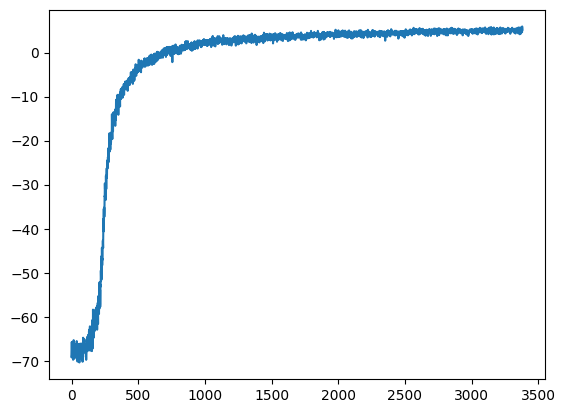

In [10]:
import matplotlib.pyplot as plt

plt.plot(reward_records)